### Basic Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('/Users/eduardo/Desktop/AssetPricing/data.csv')
#print(df.head())
#print(df.describe())
print(df.columns)

Index(['KEY', 'FREQ', 'REF_AREA', 'CURRENCY', 'PROVIDER_FM', 'INSTRUMENT_FM',
       'PROVIDER_FM_ID', 'DATA_TYPE_FM', 'TIME_PERIOD', 'OBS_VALUE',
       'OBS_STATUS', 'OBS_CONF', 'OBS_PRE_BREAK', 'OBS_COM', 'TIME_FORMAT',
       'BREAKS', 'COLLECTION', 'COMPILING_ORG', 'DISS_ORG', 'DOM_SER_IDS',
       'FM_CONTRACT_TIME', 'FM_COUPON_RATE', 'FM_IDENTIFIER', 'FM_LOT_SIZE',
       'FM_MATURITY', 'FM_OUTS_AMOUNT', 'FM_PUT_CALL', 'FM_STRIKE_PRICE',
       'PUBL_MU', 'PUBL_PUBLIC', 'UNIT_INDEX_BASE', 'COMPILATION', 'COVERAGE',
       'DECIMALS', 'SOURCE_AGENCY', 'SOURCE_PUB', 'TITLE', 'TITLE_COMPL',
       'UNIT', 'UNIT_MULT'],
      dtype='object')


### Convert `df` from long to wide and keep useful columns

In [3]:
# Parse dates
df["TIME_PERIOD"] = pd.to_datetime(df["TIME_PERIOD"])

# Keep only government bond Svensson params
mask = (
    (df["REF_AREA"] == "U2") &
    (df["CURRENCY"] == "EUR") &
    (df["PROVIDER_FM"] == "4F") &
    (df["INSTRUMENT_FM"] == "G_N_A") &
    (df["PROVIDER_FM_ID"] == "SV_C_YM")
)

df_yc = df.loc[mask, ["TIME_PERIOD", "DATA_TYPE_FM", "OBS_VALUE"]].copy()

# Pivot: rows = date, columns = parameter
yc_params = df_yc.pivot_table(
    index="TIME_PERIOD",
    columns="DATA_TYPE_FM",
    values="OBS_VALUE"
).sort_index()

needed_cols = ["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]
yc_params = yc_params[needed_cols]

yc_params.head()

DATA_TYPE_FM,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
TIME_PERIOD,,,,,,
2004-09-06,5.410510,-3.462358,-0.361335,-0.466368,3.128331,1.489535
2004-09-07,5.391886,-3.450353,-0.372908,-0.271295,3.157868,1.548566
2004-09-08,5.385978,-3.447950,-0.346505,-0.198077,3.137857,1.553148
2004-09-09,5.377333,-3.432592,-0.382208,-0.293482,3.271392,1.521143
2004-09-10,5.355732,-3.395283,-0.375382,-0.507894,3.279876,1.479197


### Implement Svensson formula & compute yields

In [4]:
# maturities in yrs
maturities = np.array([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0])

# make sure params are floats
params = yc_params[["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]].astype(float)
b0 = params["BETA0"].values
b1 = params["BETA1"].values
b2 = params["BETA2"].values
b3 = params["BETA3"].values
t1 = params["TAU1"].values
t2 = params["TAU2"].values

def svensson_spot_rate(T, beta0, beta1, beta2, beta3, tau1, tau2):

    x1 = T / tau1
    x2 = T / tau2

    # avoid division by zero
    x1 = np.where(x1 == 0, 1e-6, x1)
    x2 = np.where(x2 == 0, 1e-6, x2)

    term1 = (1.0 - np.exp(-x1)) / x1
    term2 = term1 - np.exp(-x1)
    term3 = (1.0 - np.exp(-x2)) / x2 - np.exp(-x2)

    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# build yc df: rows = dates, columns = maturities
yc_yields = pd.DataFrame(index=yc_params.index)

for T in maturities:
    yc_yields[f"y_{T}y"] = svensson_spot_rate(T, b0, b1, b2, b3, t1, t2)

### Plot each maturity evelution

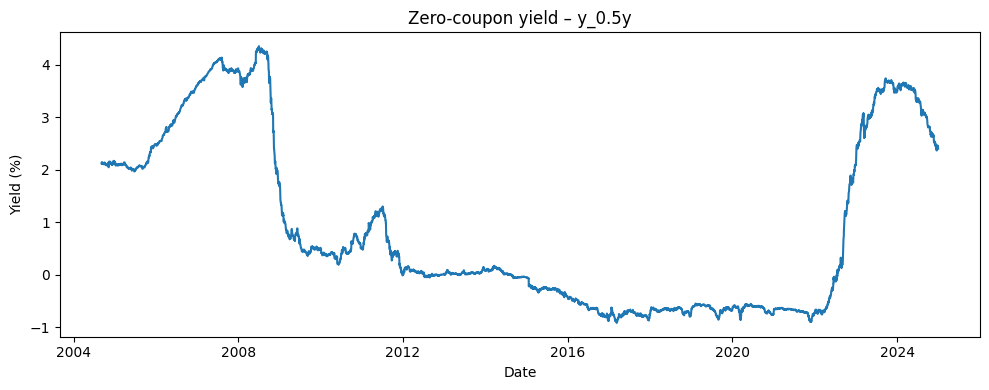

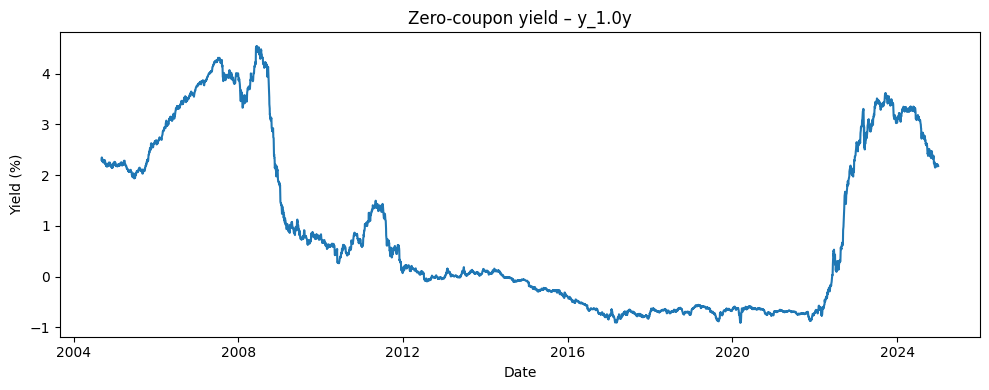

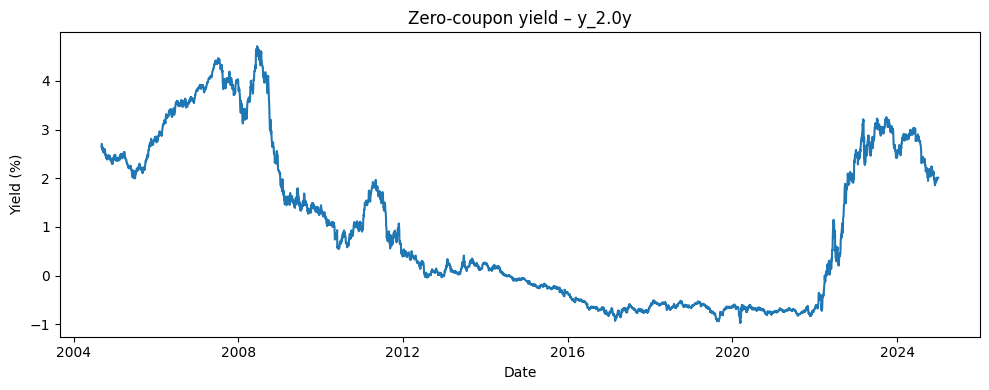

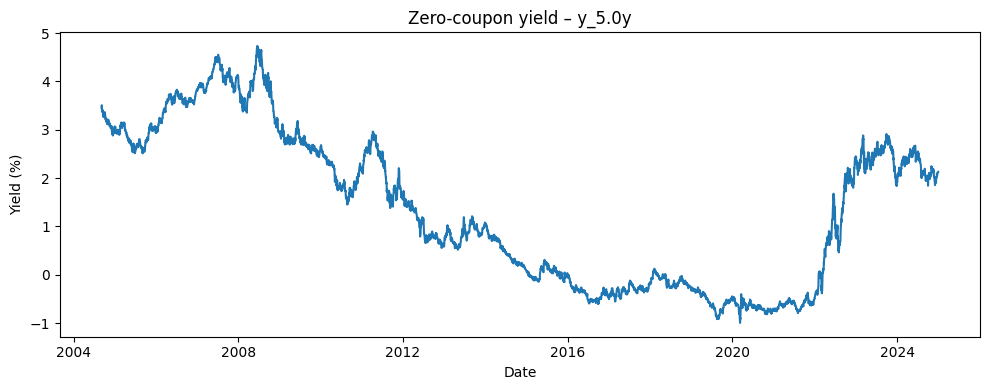

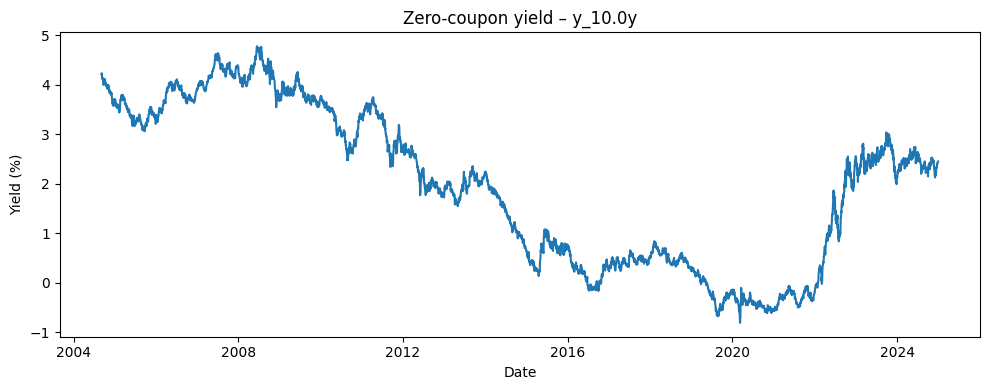

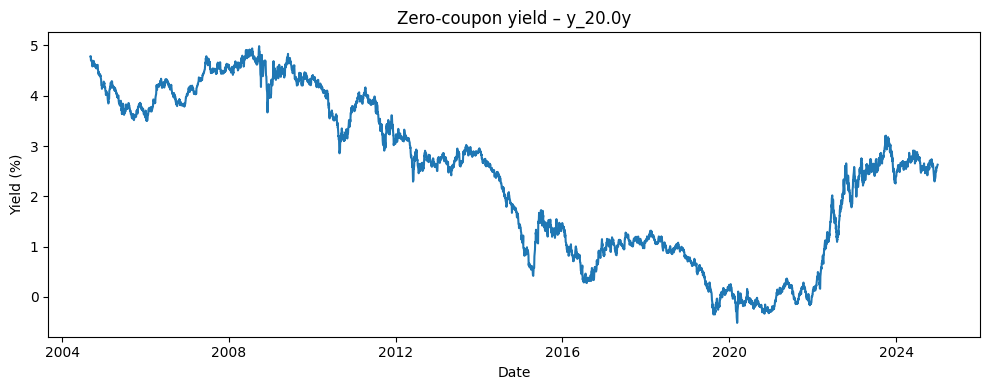

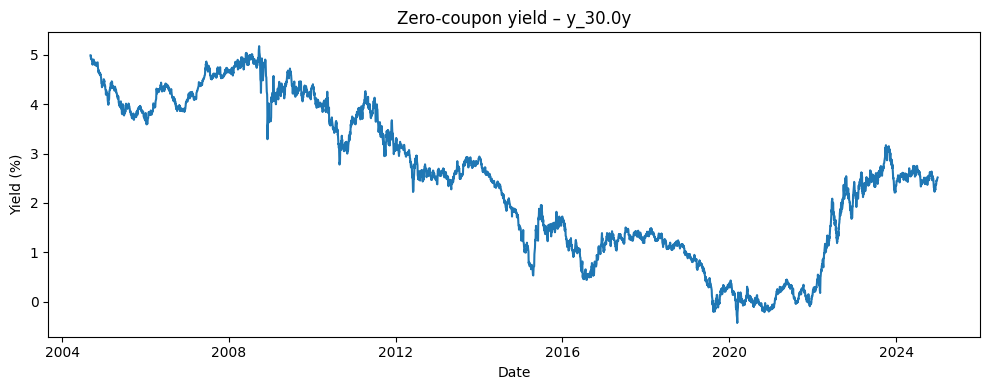

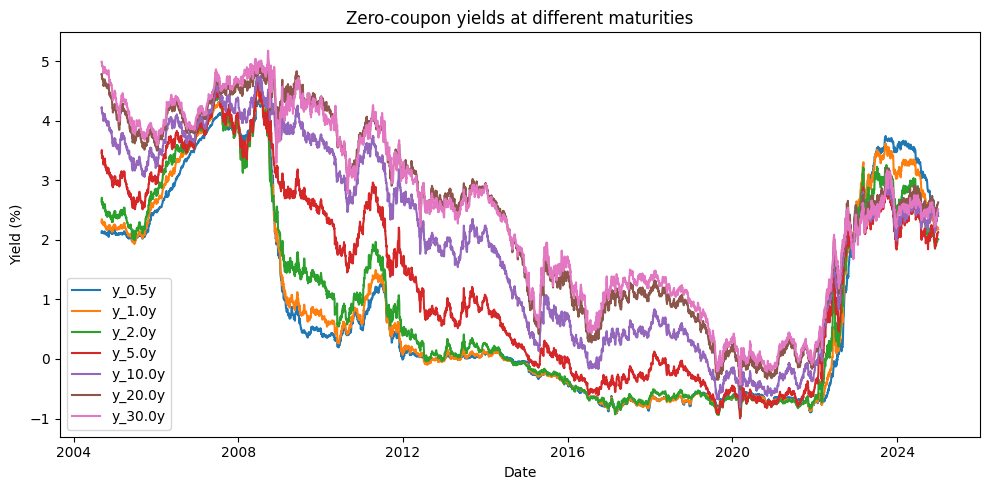

In [5]:
# A 2D plot for each maturity
for col in yc_yields.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(yc_yields.index, yc_yields[col])
    plt.title(f"Zero-coupon yield – {col}")
    plt.xlabel("Date")
    plt.ylabel("Yield (%)")
    plt.tight_layout()
    plt.show()

# One 2D plot with ALL maturities together
plt.figure(figsize=(10, 5))
for col in yc_yields.columns:
    plt.plot(yc_yields.index, yc_yields[col], label=col)

plt.title("Zero-coupon yields at different maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.tight_layout()
plt.show()



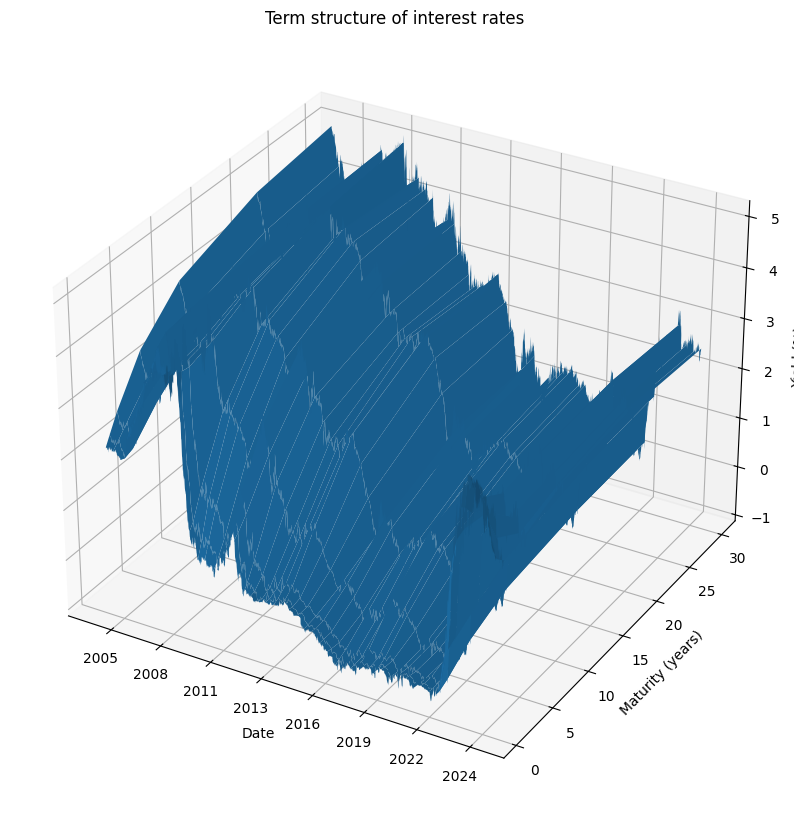

In [6]:
import matplotlib.dates as mdates

# Convert dates to numbers
dates_num = mdates.date2num(yc_yields.index.to_pydatetime())

# Extract maturities from column names
maturities = np.array([float(c.split("_")[1].replace("y", "")) for c in yc_yields.columns])

# Create grid: X = time, Y = maturity
X, Y = np.meshgrid(dates_num, maturities)

# Z = yields (transpose to match shapes: maturities × dates)
Z = yc_yields.values.T

fig = plt.figure(figsize=(10, 14))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)

ax.set_xlabel("Date")
ax.set_ylabel("Maturity (years)")
ax.set_zlabel("Yield (%)")
ax.set_title("Term structure of interest rates ")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


### Use the curve to price a 10y 3% coupon bond

In [7]:
# 10-year annual coupon bond
nominal = 100.0
coupon_rate = 0.03
T = 10
payment_times = np.arange(1, T + 1)

# Using y_10y as a flat yield for simplicity
y10 = yc_yields["y_10.0y"] / 100.0

# Compute discount factors for each payment time
df_matrix = 1.0 / (1.0 + y10.values[:, None]) ** payment_times[None, :]

# Cash flows: coupons each year + principal at maturity
coupon_cf = nominal * coupon_rate
cash_flows = np.full(T, coupon_cf, dtype=float)
cash_flows[-1] += nominal

# Bond price on each date = sum_k CF_k * DF_k
bond_prices = (df_matrix * cash_flows[None, :]).sum(axis=1)

# Put into a time series
bond_price_series = pd.Series(bond_prices, index=yc_yields.index, name="P_10y_3pct")

bond_price_series.head()


TIME_PERIOD
2004-09-06    90.293502
2004-09-07    90.290439
2004-09-08    90.148759
2004-09-09    90.651659
2004-09-10    90.962349
Name: P_10y_3pct, dtype: float64

### Plot bond price over time

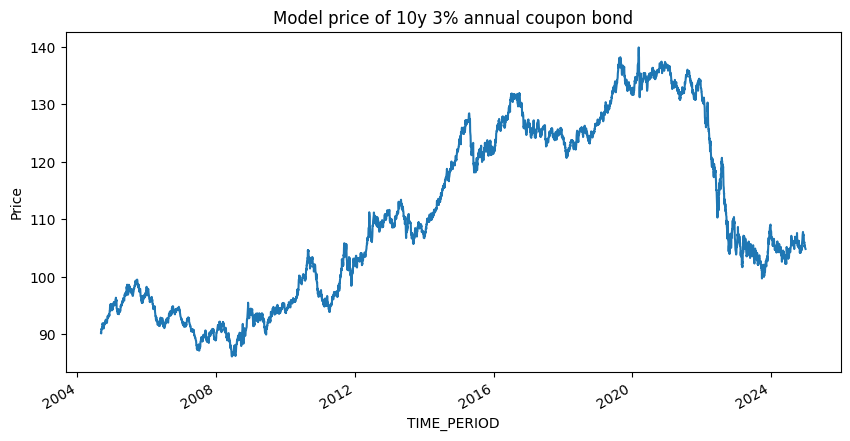

In [8]:
bond_price_series.plot(figsize=(10,5))
plt.title("Model price of 10y 3% annual coupon bond")
plt.ylabel("Price")
plt.show()

### Utility functions: discount factors & PV bond pricing

In [9]:
# Returns yield
def get_yield_on_date(yc_yields, date, maturity):
    col = f"y_{maturity}y"
    return yc_yields.loc[date, col] / 100.0

# Build discount factors using the term structure
def discount_factors_from_curve(yc_yields, date, payment_times):
    maturities_available = np.array([
        float(c.split("_")[1].replace("y", "")) for c in yc_yields.columns
    ])

    closest = []
    for t in payment_times:
        idx = np.argmin(np.abs(maturities_available - t))
        closest.append(maturities_available[idx])

    cols = [f"y_{m}y" for m in closest]
    y_vec = yc_yields.loc[date, cols].values / 100.0

    dfs = 1.0 / (1.0 + y_vec) ** payment_times
    return dfs

# Obtain Present Value
def price_coupon_bond_pv(yc_yields, date, maturity, coupon_rate,
                         face=100.0, freq=1):
    n_periods = int(maturity * freq)
    dt = 1.0 / freq

    payment_times = np.arange(1, n_periods + 1) * dt
    coupon_cf = face * coupon_rate / freq
    cash_flows = np.full(n_periods, coupon_cf, dtype=float)
    cash_flows[-1] += face

    dfs = discount_factors_from_curve(yc_yields, date, payment_times)

    price_pv = np.sum(cash_flows * dfs)
    return price_pv

In [10]:
#check
val_date = yc_yields.index[0]
pv_price = price_coupon_bond_pv(yc_yields, val_date, maturity=10, coupon_rate=0.03)
print("PV price from ECB curve:", pv_price)

PV price from ECB curve: 90.94139157095282


### Martingale-style binomial short-rate tree pricing

Simple CRR-style binomial tree for the short rate
- r0: initial short rate (decimal)
- sigma: volatility of short rate per sqrt(year)
- dt: time step in years
- N: number of time steps

Price a fixed-coupon bond on a short-rate tree under Q.
- r_tree: (N+1, N+1) array of short rates (decimal)
- q: risk-neutral up probability
- dt: length of one time step (years)
- maturity: bond maturity in YEARS
- coupon_rate: annual coupon rate (e.g. 0.03 for 3%)
- freq: coupons per year (assume dt = 1/freq)

In [11]:
# short rate tree
def build_short_rate_tree(r0, sigma, dt, N):

    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u

    # risk-neutral probability so that expected growth factor matches 1 + r0*dt
    R = 1.0 + r0 * dt
    q = (R - d) / (u - d)

    # clip q into [0,1] just in case
    q = min(max(q, 0.0), 1.0)

    r_tree = np.zeros((N + 1, N + 1))
    r_tree[0, 0] = r0

    for n in range(1, N + 1):
        for j in range(n + 1):
            r_tree[n, j] = r0 * (u ** j) * (d ** (n - j))

    return r_tree, q

# using the tree to price the bond
def price_coupon_bond_binomial(r_tree, q, dt, maturity, coupon_rate,
                               face=100.0, freq=1):

    N = int(maturity * freq)
    assert np.isclose(dt, 1.0 / freq), "dt must be 1/freq for this simple implementation"

    coupon_cf = face * coupon_rate / freq

    B = np.zeros((N + 1, N + 1))
    for j in range(N + 1):
        B[N, j] = face

    # Backward induction
    for n in range(N - 1, -1, -1):
        for j in range(n + 1):
            r = r_tree[n, j]
            expected_next = q * B[n + 1, j + 1] + (1 - q) * B[n + 1, j]
            B[n, j] = (expected_next + coupon_cf) / (1.0 + r * dt)

    return B[0, 0]

### Compare PV vs tree prices for the whole sample

In [19]:
# Bond & model specs
maturity = 10
coupon_rate = 0.03
face = 100.0
freq = 1
dt = 1.0 / freq
sigma = 0.10       # short-rate vol (per sqrt(year))

dates = yc_yields.index

results = []

for d in dates:
    # 1) Fundamental / PV price using ECB ZC curve on date d
    pv_price = price_coupon_bond_pv(
        yc_yields, d,
        maturity=maturity,
        coupon_rate=coupon_rate,
        face=face,
        freq=freq
    )

    # 2) Tree / martingale price using short-rate tree
    r0 = get_yield_on_date(yc_yields, d, maturity=1.0)

    # build short-rate tree for this date
    N = int(maturity * freq)
    r_tree, q = build_short_rate_tree(r0, sigma, dt, N)

    tree_price = price_coupon_bond_binomial(
        r_tree, q, dt,
        maturity=maturity,
        coupon_rate=coupon_rate,
        face=face,
        freq=freq
    )

    results.append({
        "date": d,
        "r0_1y": r0,
        "q_tree": q,
        "price_pv": pv_price,
        "price_tree": tree_price,
        "diff_tree_minus_pv": tree_price - pv_price
    })

prices_all = pd.DataFrame(results).set_index("date")

prices_all.head()

,r0_1y,q_tree,price_pv,price_tree,diff_tree_minus_pv
date,,,,,
2004-09-06,0.022988,0.589771,90.941392,104.123728,13.182337
2004-09-07,0.023289,0.591271,90.920771,103.799890,12.879118
2004-09-08,0.023467,0.592159,90.772408,103.608553,12.836145
2004-09-09,0.023090,0.590278,91.281389,104.014308,12.732919
2004-09-10,0.022716,0.588410,91.603367,104.417990,12.814623


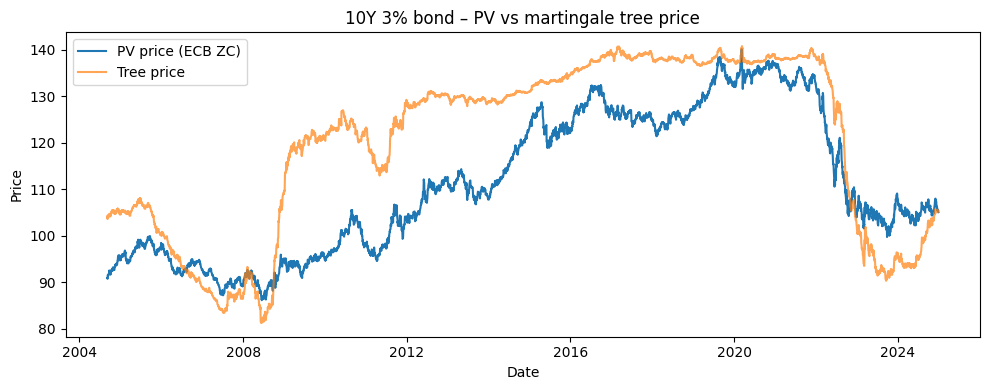

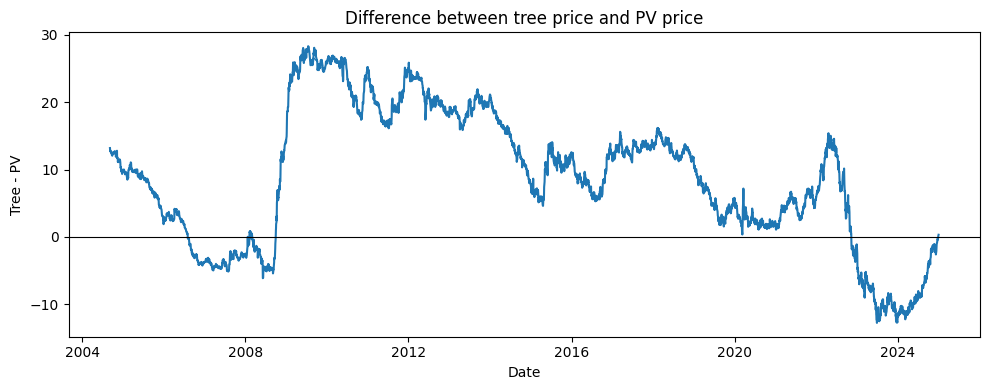

In [14]:
# Plot both price series
plt.figure(figsize=(10,5))
plt.plot(prices_all.index, prices_all["price_pv"], label="PV price (ECB ZC)")
plt.plot(prices_all.index, prices_all["price_tree"], label="Tree price", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("10Y 3% bond – PV vs martingale tree price")
plt.legend()
plt.tight_layout()
plt.show()

# Plot difference
plt.figure(figsize=(10,4))
plt.plot(prices_all.index, prices_all["diff_tree_minus_pv"])
plt.axhline(0, color="k", linewidth=0.8)
plt.xlabel("Date")
plt.ylabel("Tree - PV")
plt.title("Difference between tree price and PV price")
plt.tight_layout()
plt.show()
